第一行文本： WM HOUSE, MC HOUSE 展览馆, 交通银行, 良品铺子
文本 hidden state shape: torch.Size([768])
图像样本数: 78575
图像特征维度: 1024
类别： [np.str_('Eh-1-1'), np.str_('Eh-1-2'), np.str_('Eh-1-3'), np.str_('Eh-1-4'), np.str_('Eh-10-1'), np.str_('Eh-10-2'), np.str_('Eh-10-3'), np.str_('Eh-10-4'), np.str_('Eh-10-5'), np.str_('Eh-10-6'), np.str_('Eh-10-7'), np.str_('Eh-10-8'), np.str_('Eh-10-9'), np.str_('Eh-11-1'), np.str_('Eh-11-2'), np.str_('Eh-11-3'), np.str_('Eh-11-4'), np.str_('Eh-12-1'), np.str_('Eh-12-2'), np.str_('Eh-12-3'), np.str_('Eh-12-4'), np.str_('Eh-12-5'), np.str_('Eh-12-6'), np.str_('Eh-12-7'), np.str_('Eh-12-8'), np.str_('Eh-12-9'), np.str_('Eh-14-1'), np.str_('Eh-14-10'), np.str_('Eh-14-2'), np.str_('Eh-14-3'), np.str_('Eh-14-4'), np.str_('Eh-14-5'), np.str_('Eh-14-6'), np.str_('Eh-14-7'), np.str_('Eh-14-8'), np.str_('Eh-14-9'), np.str_('Eh-2-1'), np.str_('Eh-2-2'), np.str_('Eh-2-3'), np.str_('Eh-3-1'), np.str_('Eh-3-2'), np.str_('Eh-3-3'), np.str_('Eh-4-1'), np.str_('Eh-5-1'), np.str_('Eh-5-2')

C:\Users\17531\.conda\envs\torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\17531\.conda\envs\torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\17531\.conda\envs\torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\U

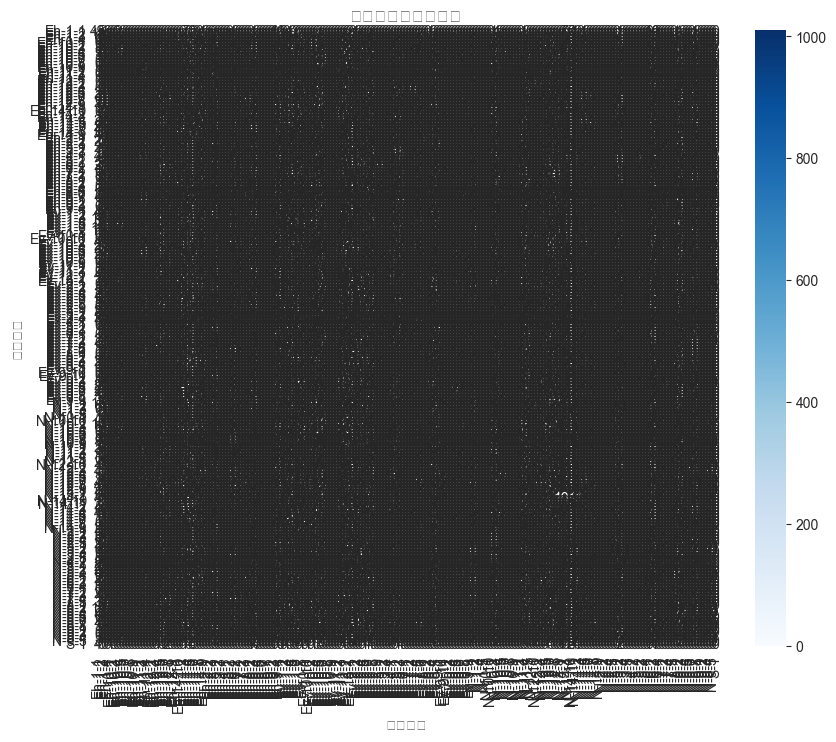

In [14]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#####################################
# 1. Text Prior: Obtain hidden state from first Excel row via BERT
#####################################
# Please modify text_data_path to your Excel file path
text_data_path = 'Final Dataset-Texts.xlsx'
df_text = pd.read_excel(text_data_path)
# Assume the Excel file has a 'List of Store Names' column
first_text = df_text['List of Store Names'].iloc[0]
print("First row text:", first_text)

# Use pre-trained BERT model (e.g., bert-base-chinese if the text is Chinese)
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
bert_model = BertModel.from_pretrained("bert-base-chinese")
bert_model.eval()  # Freeze BERT parameters
with torch.no_grad():
    inputs = tokenizer(first_text, return_tensors="pt", truncation=True, padding=True)
    outputs = bert_model(**inputs)
    # Use the [CLS] token's hidden state as the text representation
    text_hidden_state = outputs.last_hidden_state[:, 0, :]  # shape: (1, 768)
    text_hidden_state = text_hidden_state.squeeze(0)       # shape: (768,)
print("Text hidden state shape:", text_hidden_state.shape)

#####################################
# 2. Image Data Loading and Preprocessing (LR branch)
#####################################
# Please modify img_data_dir to your image dataset folder path
# Assume each subfolder name is the class label
img_data_dir = '../all'

image_features = []  # store image features (1024 dims)
img_labels = []      # store class labels

for class_name in os.listdir(img_data_dir):
    class_path = os.path.join(img_data_dir, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                try:
                    img = Image.open(os.path.join(class_path, filename))
                    img = img.convert('L')        # Convert to grayscale
                    img = img.resize((32, 32))    # Resize to 32×32
                    img_array = np.array(img).flatten()  # Flatten to 1024-dim vector
                    image_features.append(img_array)
                    img_labels.append(class_name)
                except Exception as e:
                    print(f"Error reading {os.path.join(class_path, filename)}:", e)

image_features = np.array(image_features, dtype='float32') / 255.0
img_labels = np.array(img_labels)
classes = sorted(np.unique(img_labels))
print("Number of image samples:", image_features.shape[0])
print("Image feature dimension:", image_features.shape[1])
print("Classes:", classes)

#####################################
# 3. Construct Dataset and DataLoader
#####################################
class ImageDataset(Dataset):
    def __init__(self, features, labels, classes):
        self.features = features  # shape: (N, 1024)
        self.labels = labels      # string labels
        self.class2idx = {cls: i for i, cls in enumerate(classes)}
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.class2idx[self.labels[idx]]
        return x, y

X_train, X_test, y_train, y_test = train_test_split(
    image_features, img_labels, test_size=0.5, random_state=42, stratify=img_labels
)
train_dataset = ImageDataset(X_train, y_train, classes)
test_dataset = ImageDataset(X_test, y_test, classes)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print("Training samples:", len(train_dataset), "Test samples:", len(test_dataset))

#####################################
# 4. Define Multimodal Fusion Model (LR hidden state + BERT hidden state)
#####################################
# Image branch (LR branch): simple MLP mapping 1024-dim image features to 128-dim hidden vector
# Text branch: fixed 768-dim BERT hidden state (as class prior)
# Fuse and decode to final class
class MultiModalFusion(nn.Module):
    def __init__(self, image_input_dim=1024, image_hidden_dim=128, text_dim=768, num_classes=len(classes)):
        super(MultiModalFusion, self).__init__()
        self.image_branch = nn.Sequential(
            nn.Linear(image_input_dim, image_hidden_dim),
            nn.ReLU()
        )
        fusion_dim = image_hidden_dim + text_dim
        self.decoder = nn.Linear(fusion_dim, num_classes)
    
    def forward(self, x, text_vec):
        # x: [batch_size, 1024]
        # text_vec: [text_dim], fixed here, needs expansion to batch_size
        img_hidden = self.image_branch(x)  # [batch_size, image_hidden_dim]
        batch_size = x.size(0)
        text_expanded = text_vec.unsqueeze(0).expand(batch_size, -1)  # [batch_size, text_dim]
        fusion = torch.cat([img_hidden, text_expanded], dim=1)        # [batch_size, fusion_dim]
        logits = self.decoder(fusion)                                 # [batch_size, num_classes]
        return logits

num_classes = len(classes)
model = MultiModalFusion(image_input_dim=1024, image_hidden_dim=128, text_dim=768, num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
text_hidden_state = text_hidden_state.to(device)

#####################################
# 5. Train Model
#####################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        logits = model(batch_x, text_hidden_state)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)
    epoch_loss = running_loss / len(train_dataset)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

#####################################
# 6. Model Evaluation
#####################################
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        logits = model(batch_x, text_hidden_state)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(batch_y.cpu().numpy())

acc = accuracy_score(all_targets, all_preds)
print("Test set accuracy:", acc)
print("Classification report:")
print(classification_report(all_targets, all_preds, target_names=classes))

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Multimodal Model Confusion Matrix")
plt.show()
